# Capstone - Problem Statement
The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.
Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.
With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, need to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

In [1]:
# Importing necessary library
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from time import time
import re

# NLP Libraries
import sklearn
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import collections
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from IPython.display import Markdown, display

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the dataset
df = pd.read_csv("sample30.csv", parse_dates = False)

In [3]:
# Checking the data
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [4]:
# Shape of the data
df.shape

(30000, 15)

In [5]:
# Checking the columns
df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_userCity',
       'reviews_userProvince', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [6]:
# Checking the columns data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

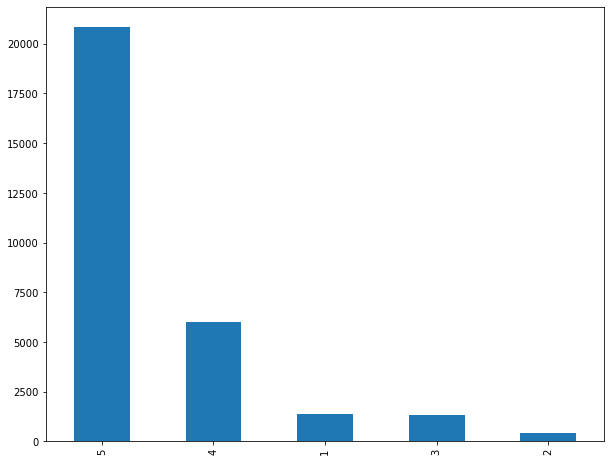

In [7]:
# Plotting the bar the for reviews_rating counts
plt.figure(figsize=(10,8))
df['reviews_rating'].value_counts().plot(kind='bar')
plt.show()

#### OBSERVATION: The above graph shows that most people are somehow satisfied with the products offered at Ebuss. From above graph we can conclude that most people are somehow satisfied with the products offered at Ebuss.

True     0.862667
False    0.051667
Name: reviews_doRecommend, dtype: float64


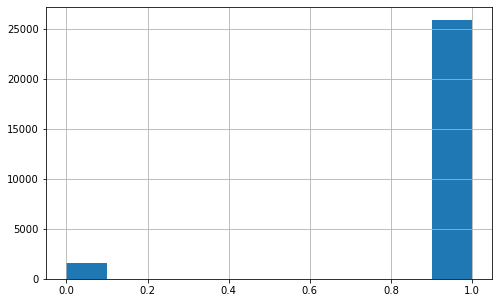

In [8]:
# Lets see how people have recommended the products
print(df["reviews_doRecommend"].value_counts()/len(df))
df["reviews_doRecommend"].astype(float).hist(figsize=(8,5))
plt.show()

#### OBSERVATION: This also gives a good understanding that people are satified with product and recommended.

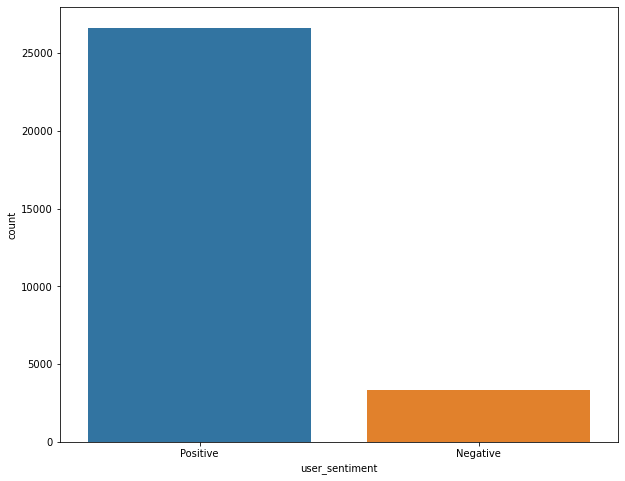

In [9]:
# Plot to show the user sentiment for Ebuss products
plt.figure(figsize=(10,8))
ax = sns.countplot(x='user_sentiment', data=df)

#### OBSERVATION: User sentiment also shows positive response on Ebuss products

In [10]:
# percentage of missing data in each columns
round(100*(df.isnull().sum()/len(df.index)), 2)

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64

In [11]:
# The columns reviews_userCity and reviews_userProvince has more than 90 percent NAN, so dropping those columns
df=df.drop(["reviews_userCity","reviews_userProvince"],axis=1)

In [12]:
# Create a new dataframe to have not null review_date features
df1 = df[~df.reviews_date.isna()]

In [13]:
# Add a column for year
df1['year'] = df1['reviews_date'].apply(lambda x:x[:4])

In [14]:
# Check the data
df1.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,year
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,2012
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,2017
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive,2017
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,2016
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,2016


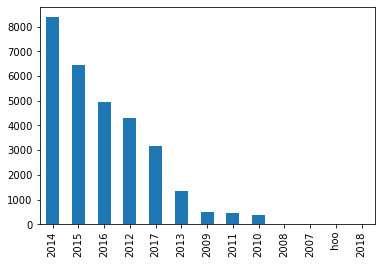

In [15]:
# Plot to show the counts of review by year
df1['year'].value_counts().plot(kind='bar')
plt.show()

#### OBSERVATION: Review date gives us information like in 2014 people reviewed more and there is drop in review products after that  or the dataset is having more records from that year.

In [16]:
# Lets check how many brands are available in provided dataset
df['brand'].unique()

array(['Universal Music', 'Lundberg', 'K-Y', 'J.R. Watkins', 'AMBI',
       "Johnson's", 'Olay', 'Windex', 'Heinz', 'KIND', 'Pantene',
       'Aussie', 'Disney', 'CeraVe', 'Solo Foods', 'Finish',
       'Jake And The Neverland Pirates', 'Pearhead', 'No Brand',
       'Neutrogena', 'Meguiars', 'Banana Boat', 'Cetaphil', 'Suave',
       'Bumble Bee', 'Citrus Magic', 'La Tortilla Factory',
       'Target.com Use Only', 'Sea Gull Lighting', 'The Seaweed Bath Co.',
       'Way Basics', 'Biokleen', 'Yes to Carrots', 'Alberto VO5',
       'Warner Bros.', 'FOX', 'Progresso', "Herr's", 'Hawaiian Punch',
       'Moom', 'Universal Home Video', 'Holmes', 'Sony Music', 'Beanitos',
       'Baxton Studio', "Nature's Path", 'Lite Source',
       'SLOAN VALVE COMPANY', 'Nearly Natural', 'Toy Story', 'MaraNatha',
       'Chex', 'TRESemme', 'Wagan', 'Creme Of Nature', 'Arrid',
       'Eagle Brand', 'Pinaud', 'Hortense B. Hewitt', 'Canada Dry',
       'Baxter of California', 'Ragu', 'Sabra', 'Pendaflex',


In [17]:
# There are lots of brands, lets check top 10 brands customers has purchased and reviewed
df.groupby('brand')['brand'].count().sort_values(ascending=False).head(10)

brand
Clorox                  10585
Warner Home Video        3325
Disney                   1200
L'oreal Paris            1186
FOX                       887
Burt's Bees               881
Sony Pictures             845
Summit Entertainment      813
Nexxus                    693
Universal Home Video      668
Name: brand, dtype: int64

#### OBSERVATION: Clorox, Warner Home Video, Disney, L'oreal Paris, FOX, Burt's Bees, Sony Pictures, Summit Entertainment, Nexxus and Universal Home Video are the top brand products customer has purchased.

In [18]:
# Let's check top 10 products from which brand are customer choice
df.groupby('brand')['name'].value_counts().sort_values(ascending=False).head(10)

brand                 name                                                                          
Clorox                Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8545
Warner Home Video     Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3325
Clorox                Clorox Disinfecting Bathroom Cleaner                                              2039
L'oreal Paris         L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Disney                Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1143
Burt's Bees           Burt's Bees Lip Shimmer, Raisin                                                    873
Sony Pictures         The Resident Evil Collection 5 Discs (blu-Ray)                                     845
FOX                   Mike Dave Need Wedding Dates (dvd + Digital)                                       757
Nexxus                Nexxu

In [19]:
# Lets check the manufacturer column in which there are .47% missing data
df[df['manufacturer'].isnull()].head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
22210,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-03-05T00:00:00.000Z,NaN,False,1,I have read the entire Alex Cross series and I...,Disappointing casting,poorcrossing,Negative
22211,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2013-10-11T00:00:00.000Z,NaN,False,1,Idris Elba was originally cast in the lead rol...,Atrocious casting,naberios,Positive
22212,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2017-06-11T00:00:00.000Z,NaN,False,2,I was way more excited or this movie than I sh...,Meh,jz30,Positive
22213,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2014-12-27T00:00:00.000Z,NaN,False,2,I'm a huge fan of James Patterson and although...,Disappointing Movie,david,Positive
22214,AVpfOIrkilAPnD_xXgDG,Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,In...",NaN,Alex Cross (dvdvideo),2015-12-26T20:30:31.000Z,NaN,True,3,"not as exciting as the book, but very good",Alex Cross Dvd,bobc,Positive


In [20]:
# Lets check which brands have missing manufacturer column data
df[df['manufacturer'].isnull()]['brand'].drop_duplicates()

22210    Summit Entertainment
Name: brand, dtype: object

In [21]:
# From above we can see that Summit Entertainment Brand has the column of manufacturer missing.
# We can impute the column of manufacturer corresponding to Summit Entertainment with the same
df.manufacturer.fillna(df.brand,inplace= True)

In [22]:
# Let see top manufacturers for each brand
df.groupby('brand')['manufacturer'].value_counts().sort_values(ascending=False).head(10)

brand                 manufacturer          
Clorox                Clorox                    8546
Warner Home Video     Test                      3325
Clorox                AmazonUs/CLOO7            2039
L'oreal Paris         L'oreal Paris             1186
Disney                Walt Disney               1143
Burt's Bees           Burt's Bees                873
Sony Pictures         SONY CORP                  845
Summit Entertainment  Summit Entertainment       813
FOX                   Twentieth Century Fox      757
Nexxus                Nexxus Beauty Products     693
Name: manufacturer, dtype: int64

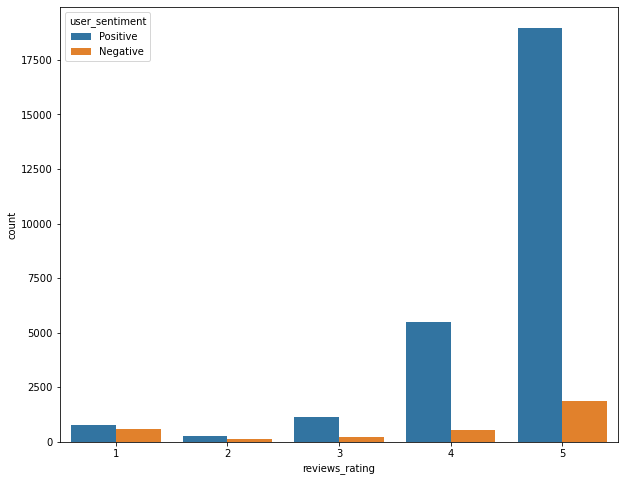

In [23]:
# Lets see how rating and user sentiment are in sync or it differs
plt.figure(figsize=(10,8))
ax = sns.countplot(x='reviews_rating', hue="user_sentiment", data=df)

#### OBSERVATION: Looking at rating and user sentiment, it does not feel like they are in sync as for customer rating 5 the sentiment is considered as negative .
#### We need to create the sentiment using rating for each product.

In [24]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [25]:
# Lets see reveiws_usename, so a user have multiple times reviewed the products
df["reviews_username"].value_counts()

byamazon customer    41
mike                 41
chris                32
lisa                 16
sandy                15
                     ..
amymarie1375          1
barvlus               1
galagal               1
bns4                  1
mrdrprofnick          1
Name: reviews_username, Length: 24914, dtype: int64

In [26]:
# Rating count given for the product
rating_per_product = df.groupby(by='id')['reviews_rating'].count().sort_values(ascending=False)
df.groupby(by='id')['reviews_rating'].count().sort_values(ascending=False)

id
AVpf3VOfilAPnD_xjpun    8545
AVpfPaoqLJeJML435Xk9    3325
AVpfJP1C1cnluZ0-e3Xy    2039
AVpfW8y_LJeJML437ySW    1186
AVpfRTh1ilAPnD_xYic2    1143
                        ... 
AVpfF7k8ilAPnD_xUyWf       1
AVpfErGsLJeJML431yRX       1
AVpfDflP1cnluZ0-c5RJ       1
AVpfBuqY1cnluZ0-cTBI       1
AVpfDbSP1cnluZ0-c3wo       1
Name: reviews_rating, Length: 271, dtype: int64

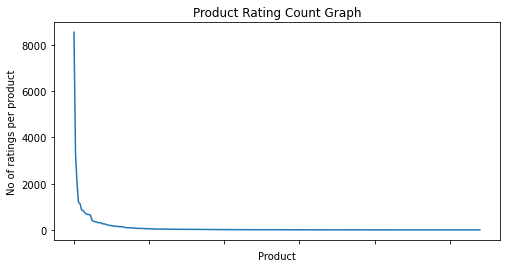

In [27]:
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(rating_per_product.values)
plt.title('Product Rating Count Graph')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])
plt.show()

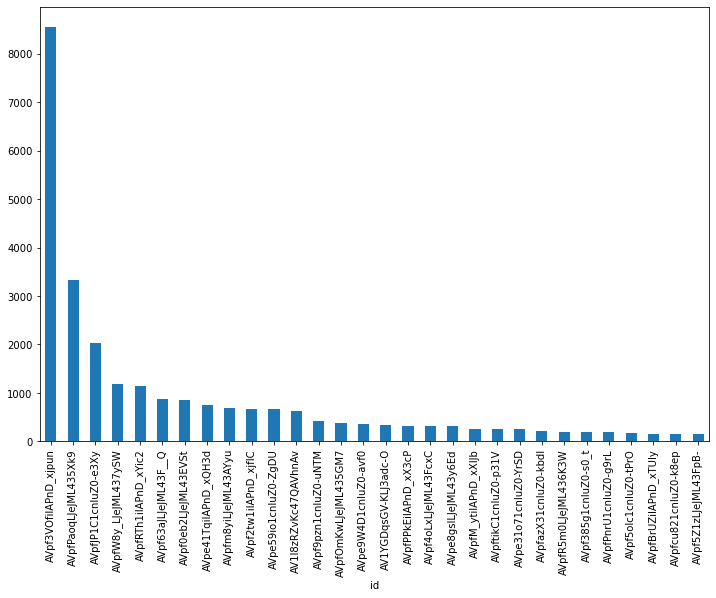

In [28]:
plt.figure(figsize=(12,8))
rating_per_product.head(30).plot(kind= "bar")
plt.show()

#### OBSERVATION: There are many products which is having very less rating and those products will not be recommended by model as not having much data for modelling. We are keeping those records to increase the corpus.

In [29]:
# Lets see the data for review_text & review_title columns
df["reviews_text"].head()

0    i love this album. it's very good. more to the...
1    Good flavor. This review was collected as part...
2                                         Good flavor.
3    I read through the reviews on here before look...
4    My husband bought this gel for us. The gel cau...
Name: reviews_text, dtype: object

In [30]:
df["reviews_title"].head()

0    Just Awesome
1            Good
2            Good
3    Disappointed
4      Irritation
Name: reviews_title, dtype: object

In [31]:
df["reviews_text"]=df["reviews_text"].astype('str')
df["reviews_title"]=df["reviews_title"].astype('str')

In [32]:
# Max and Min length of reviews_text
print(max(len(i) for i in df.reviews_text))
print(min(len(i) for i in df.reviews_text))

5865
2


In [33]:
# Max and Min length of reviews_title
print(max(len(i) for i in df.reviews_title))
print(min(len(i) for i in df.reviews_title))

180
1


In [34]:
# We should use both columns for text processing, so creating a new column by concatenating both columns
df['text'] = [' '.join(i) for i in zip(df["reviews_text"].map(str),df["reviews_title"])]

In [35]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,Good flavor. This review was collected as part...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive,Good flavor. Good
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,I read through the reviews on here before look...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,My husband bought this gel for us. The gel cau...


## Text Processing

#### Taking only features needed for modelling

In [36]:
df_txt = df[['reviews_username', 'name','text', 'reviews_rating']]

In [37]:
df_txt.head()

,reviews_username,name,text,reviews_rating
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,5
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,5
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. Good,5
3,rebecca,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,1
4,walker557,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,1


In [38]:
df_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  29937 non-null  object
 1   name              30000 non-null  object
 2   text              30000 non-null  object
 3   reviews_rating    30000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 937.6+ KB


In [39]:
round(100*(df_txt.isnull().sum()/len(df_txt.index)), 2)

reviews_username    0.21
name                0.00
text                0.00
reviews_rating      0.00
dtype: float64

#### OBSERVATION: There are few records missing with username, but for sentiment analysis modelling the username feature is not needed.

Product rating range from 1 to 5. As per the EDA done earlier, the provided user_sentiment column is not in sync with rating, so creating
a sentiment feature as positive or negative based on rating
Rating greater than 3 consider as positive review & less then 3 set as negative review

In [40]:
df_txt['sentiment']=df_txt['reviews_rating'].apply(lambda x: 'Positive' if x >=3 else 'Negative')

In [41]:
df_txt.head()

,reviews_username,name,text,reviews_rating,sentiment
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,5,Positive
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,5,Positive
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. Good,5,Positive
3,rebecca,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,1,Negative
4,walker557,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,1,Negative


In [42]:
## droping all columns not needed for modelling

In [43]:
df_txt=df_txt.drop(["reviews_rating", "reviews_username", "name", "reviews_rating"],axis=1)

In [44]:
df_txt.head()

,text,sentiment
0,i love this album. it's very good. more to the...,Positive
1,Good flavor. This review was collected as part...,Positive
2,Good flavor. Good,Positive
3,I read through the reviews on here before look...,Negative
4,My husband bought this gel for us. The gel cau...,Negative


####  Lowercase

In [45]:
# Function to lowercase the words
def words(sent):
    "Convert text to lower case and tokenise the document"
    return re.findall(r'\w+', sent.lower())

#### Text cleaning
lower case
remove integer
remove special characters
stop words
spell correction

In [46]:
def clean_text(text):
        
    # Convert words to lower case
    text = text.lower()
    corrected_words = []
    sent = []
    
    # Format words and remove unwanted characters   
    text = re.sub(r'\n', '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'//', '', text)
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@$\[\]]', ' ', text)
    
    # Remove stop words
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    
    return text

In [47]:
# Clean the description
for row in df_txt.iterrows():
    row[1]['text'] = clean_text(row[1]['text'])

In [48]:
clean_text("i love this album. it's very good. more to the")

'love album good'

In [49]:
df_txt.head()

,text,sentiment
0,love album good hip hop side current pop sound...,Positive
1,good flavor review collected part promotion good,Positive
2,good flavor good,Positive
3,read reviews looking buying one couples lubric...,Negative
4,husband bought gel us gel caused irritation fe...,Negative


In [50]:
# Word corpus count
print('Unique words: {}'.format(len({word for desc in df_txt.text for word in desc.split()})))

Unique words: 19097


In [51]:
# Create the word vocab
import collections
words = [word for desc in df_txt.text for word in desc.split()]
word_counts = collections.Counter(words)

In [52]:
word_counts

Counter({'love': 11325,
         'album': 102,
         'good': 6793,
         'hip': 2,
         'hop': 2,
         'side': 191,
         'current': 43,
         'pop': 81,
         'sound': 187,
         'hype': 17,
         'listen': 46,
         'everyday': 551,
         'gym': 23,
         'give': 386,
         'star': 126,
         'rating': 33,
         'way': 1296,
         'metaphors': 1,
         'crazy': 118,
         'awesome': 1844,
         'flavor': 269,
         'review': 9239,
         'collected': 8745,
         'part': 9065,
         'promotion': 8747,
         'read': 156,
         'reviews': 229,
         'looking': 771,
         'buying': 314,
         'one': 3847,
         'couples': 4,
         'lubricants': 2,
         'ultimately': 10,
         'disappointed': 501,
         'even': 1403,
         'live': 314,
         'starters': 4,
         'neither': 15,
         'boyfriend': 32,
         'could': 824,
         'notice': 112,
         'sort': 54,
         'e

### Lemmatising

In [53]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemprocess(document):
    
    # tokenize into words
    words = word_tokenize(document)
    
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    
    # join words to make sentence
    document = " ".join(words)
    
    return document

In [54]:
df_txt.head()

,text,sentiment
0,love album good hip hop side current pop sound...,Positive
1,good flavor review collected part promotion good,Positive
2,good flavor good,Positive
3,read reviews looking buying one couples lubric...,Negative
4,husband bought gel us gel caused irritation fe...,Negative


In [55]:
df_txt["text"] = df_txt["text"].apply(lambda x: lemprocess(x))

In [56]:
df_txt.head()

,text,sentiment
0,love album good hip hop side current pop sound...,Positive
1,good flavor review collect part promotion good,Positive
2,good flavor good,Positive
3,read review look buy one couple lubricants ult...,Negative
4,husband buy gel us gel cause irritation felt l...,Negative


In [57]:
# After lemmatization, words are converted to its base form
# like 4th index text word 'bought' changed to its base form - 'buy'

In [58]:
!pip install wordcloud

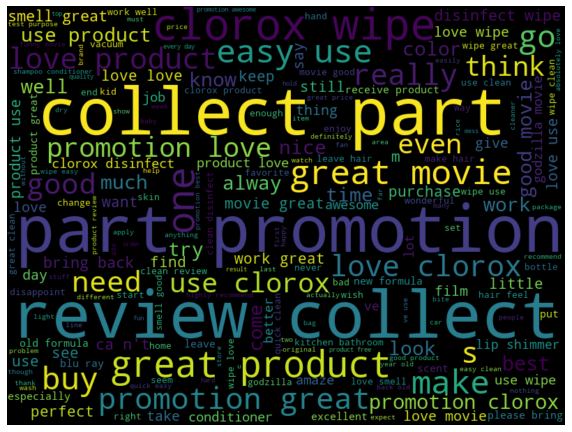

In [59]:
# Let's form the word cloud
# A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller size
all_words = ' '.join([text for text in df_txt['text']])

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 600, random_state = 21, max_font_size = 120).generate(all_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
df_txt["sentiment"].value_counts()

Positive    28196
Negative     1804
Name: sentiment, dtype: int64

#### TFIDF Vectorizer

In [61]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,1), min_df = 0.1) 
 
# vectorize the complete text
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(df_txt['text'])

In [62]:
(tfidf_vectorizer_vectors)

<30000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 124263 stored elements in Compressed Sparse Row format>

In [63]:
df_txt.head(2)

,text,sentiment
0,love album good hip hop side current pop sound...,Positive
1,good flavor review collect part promotion good,Positive


In [64]:
df['text'].head()

0    i love this album. it's very good. more to the...
1    Good flavor. This review was collected as part...
2                                    Good flavor. Good
3    I read through the reviews on here before look...
4    My husband bought this gel for us. The gel cau...
Name: text, dtype: object

In [65]:
# Saving the cleaned up text in original dataset to use it during user interface.
df['text'] = df_txt['text']

In [66]:
df['text'].head()

0    love album good hip hop side current pop sound...
1       good flavor review collect part promotion good
2                                     good flavor good
3    read review look buy one couple lubricants ult...
4    husband buy gel us gel cause irritation felt l...
Name: text, dtype: object

### Creating pickle files for tdidf vectorizer and data for deployment

In [67]:
pkl.dump(tfidf_vectorizer, open("./models/tfidf.pkl", "wb"))
pkl.dump(df, open("./dataset/transform.pkl", "wb"))

In [68]:
# Converting user_sentiment in binary form
df_txt["sentiment"]=df_txt["sentiment"].apply(lambda x: 1 if x =='Positive' else 0)

In [69]:
df_txt.head()

,text,sentiment
0,love album good hip hop side current pop sound...,1
1,good flavor review collect part promotion good,1
2,good flavor good,1
3,read review look buy one couple lubricants ult...,0
4,husband buy gel us gel cause irritation felt l...,0


In [70]:
model_results = pd.DataFrame()
def get_model_metrics(y_test, y_pred, model_name):
    accuracy = round(accuracy_score(y_test,y_pred), 4)
    data = [[model_name, accuracy]] 
    df = pd.DataFrame(data, columns = ['Model Name', 'Accuracy'])
    global model_results 
    model_results = model_results.append(df, ignore_index=True)
    return df 

## Model Building
### We will build 4 models as below:
1. Random Forest
2. Random Forest with hyper parameter tuning
3. Logistic regression
4. XG Boost Classifier

There is an imbalance is user_sentiment class, number of positives are more and number of negatives are less. We will be handling class imbalance during/before modelling.

### SMOTE for class imbalance

In [71]:
# Dividing data into test & train to build sentiment analysis model
# Putting feature variable to X
X = tfidf_vectorizer_vectors

# Putting response variable to y
y = df_txt["sentiment"]
# split into 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =100)

In [72]:
# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (22500, 19)
Number transactions y_train dataset:  (22500,)
Number transactions X_test dataset:  (7500, 19)
Number transactions y_test dataset:  (7500,)


### SMOTE for class imbalance

In [73]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [74]:
from imblearn.combine import SMOTETomek
os=SMOTETomek(0.75)
X_train_ns,y_train_ns=os.fit_resample(X_train,y_train)

In [75]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_train_ns.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_ns.shape))
 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_ns == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_ns == 0)))

Before OverSampling, counts of label '1': 21130
Before OverSampling, counts of label '0': 1370 

After OverSampling, the shape of train_X: (36947, 19)
After OverSampling, the shape of train_y: (36947,) 

After OverSampling, counts of label '1': 21115
After OverSampling, counts of label '0': 15832


### Training the model
## Random Forest

In [76]:
rf = RandomForestClassifier()
rf.fit(X_train_ns,y_train_ns)

RandomForestClassifier()

In [77]:
y_pred=rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 256  178]
 [ 841 6225]]
0.8641333333333333
              precision    recall  f1-score   support

           0       0.23      0.59      0.33       434
           1       0.97      0.88      0.92      7066

    accuracy                           0.86      7500
   macro avg       0.60      0.74      0.63      7500
weighted avg       0.93      0.86      0.89      7500



In [78]:
# Print the model metrics
get_model_metrics(y_test, y_pred ,'Random Forest')

,Model Name,Accuracy
0,Random Forest,0.8641


### Random Forest has a good accuracy score of 86%

No handles with labels found to put in legend.


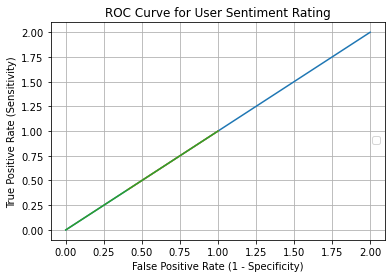

In [79]:
from sklearn.metrics import roc_auc_score, roc_curve
plt.plot(roc_curve(y_test, y_pred), roc_curve(y_test, y_pred))
plt.title('ROC Curve for User Sentiment Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(bbox_to_anchor=(1.0, .5))
plt.show()

Let's hypertune Random forest using randomised search

### Training the model
## Random Forest with Hyper Parameter Tuning (HPT)

In [80]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
min_samples_split = [2, 5, 10, 14]
min_samples_leaf = [1, 2, 4, 6, 8]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [81]:
rf1 = RandomForestClassifier()
rf_randomcv = RandomizedSearchCV(estimator=rf1,param_distributions=random_grid,n_iter=10,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
# Fit the randomized model
rf_randomcv.fit(X_train_ns,y_train_ns)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbose=2)

In [82]:
rf_randomcv.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 120,
 'criterion': 'entropy'}

In [83]:
rf_randomcv

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbose=2)

In [84]:
best_random_grid = rf_randomcv.best_estimator_

In [85]:
y_pred = best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[ 261  173]
 [ 850 6216]]
Accuracy Score 0.8636
Classification report:               precision    recall  f1-score   support

           0       0.23      0.60      0.34       434
           1       0.97      0.88      0.92      7066

    accuracy                           0.86      7500
   macro avg       0.60      0.74      0.63      7500
weighted avg       0.93      0.86      0.89      7500



In [86]:
# Print the model metrics
get_model_metrics(y_test, y_pred ,'Random Forest with HPT')

,Model Name,Accuracy
0,Random Forest with HPT,0.8636


### Training the model
## Logistic Regression

In [87]:
lr = LogisticRegression()
lr.fit(X_train_ns,y_train_ns)

LogisticRegression()

In [88]:
y_pred2 = lr.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[ 333  101]
 [1318 5748]]
0.8108
              precision    recall  f1-score   support

           0       0.20      0.77      0.32       434
           1       0.98      0.81      0.89      7066

    accuracy                           0.81      7500
   macro avg       0.59      0.79      0.60      7500
weighted avg       0.94      0.81      0.86      7500



In [89]:
# Print the model metrics
get_model_metrics(y_test, y_pred2 ,'Logistic Regression')

,Model Name,Accuracy
0,Logistic Regression,0.8108


### Training the model
## XGBoost Regression

In [90]:
xgb_model = xgb.XGBClassifier(n_jobs = -1, objective = 'binary:logistic')
xgb_model.fit(X_train_ns, y_train_ns)

[23:30:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
y_pred3 = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred3]

In [92]:
accuracy = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[ 288  146]
 [ 972 6094]]
0.8509333333333333
              precision    recall  f1-score   support

           0       0.23      0.66      0.34       434
           1       0.98      0.86      0.92      7066

    accuracy                           0.85      7500
   macro avg       0.60      0.76      0.63      7500
weighted avg       0.93      0.85      0.88      7500

Accuracy: 85.09%


In [93]:
# Print the model metrics
get_model_metrics(y_test, y_pred3 ,'XGBoost Regression')

,Model Name,Accuracy
0,XGBoost Regression,0.8509


In [94]:
model_results.head(10)

,Model Name,Accuracy
0,Random Forest,0.8641
1,Random Forest with HPT,0.8636
2,Logistic Regression,0.8108
3,XGBoost Regression,0.8509


## Among all the models tested for Sentiment analysis, Random Forest has performed the best in term of accuracy and performance. So, taking Random Forest as final model for sentiment analysis

In [95]:
# Save the best model in pickle file for deployment
pkl.dump(rf, open('./models/best_model.pkl', 'wb'))

# Recommendation system

### Exploratory Data Analysis already performed during sentiment analysis to understand the data. For recommendation system, only rating column, product name and username are required, so directly performing User based recommendation and Item based recommendation

In [96]:
df=pd.read_csv("sample30.csv", usecols=['name', 'reviews_rating', 'reviews_username'])
df.head()

,name,reviews_rating,reviews_username
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,K-Y Love Sensuality Pleasure Gel,1,walker557


In [97]:
round(100*(df.isnull().sum()/len(df.index)),2)

name                0.00
reviews_rating      0.00
reviews_username    0.21
dtype: float64

In [98]:
# Dropping the records doesn't have username as username name is needed for any recommendation
df.dropna(subset=['reviews_username'], inplace=True)

In [99]:
df.dropna(subset=['name'], inplace=True)

In [100]:
df.shape

(29937, 3)

In [101]:
# Lets check if there are any duplicate records per user for a product/name provided
df[df.duplicated(["name","reviews_username"])]

,name,reviews_rating,reviews_username
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
12,K-Y Love Sensuality Pleasure Gel,1,jds1992
44,"Johnson's Baby Bubble Bath and Wash, 15oz",4,solo
79,Olay Regenerist Deep Hydration Regenerating Cream,3,mylifeinheels
90,Olay Regenerist Deep Hydration Regenerating Cream,3,mylifeinheels
...,...,...,...
29807,L'or233al Paris Elvive Extraordinary Clay Reba...,5,joycakes
29827,L'or233al Paris Elvive Extraordinary Clay Reba...,5,emily95
29841,L'or233al Paris Elvive Extraordinary Clay Reba...,5,brookieboo1994
29921,L'or233al Paris Elvive Extraordinary Clay Reba...,5,talmariejohn


In [102]:
# A user have duplicate review for the same product
df[df["reviews_username"] =="filo123"]

,name,reviews_rating,reviews_username
29668,L'or233al Paris Elvive Extraordinary Clay Reba...,5,filo123
29944,L'or233al Paris Elvive Extraordinary Clay Reba...,5,filo123


In [103]:
# Removing the duplicate records 
df.drop_duplicates(subset=["name","reviews_username"],inplace=True)
df.shape

(27588, 3)

### Dividing the dataset into train and test

In [104]:
# Test and Train split of the dataset.
train, test = train_test_split(df, test_size=0.30, random_state=31)

In [105]:
print(train.shape)
print(test.shape)

(19311, 3)
(8277, 3)


In [106]:
# Pivot the train ratings dataset into matrix format in which columns are products and the rows are usernames.
df_pivot = train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head(5)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset
These datasets will be used for prediction

Dummy train will be used later for prediction of the product which has not been rated by the user. To ignore the product rated by the user, we will mark it as 0 during prediction. The product not rated by user is marked as 1 for prediction in dummy train dataset.

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [107]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [108]:
# The product not rated by user is marked as 1 for prediction. 
dummy_train['rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [109]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [110]:
dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors which is Rating Vector in this case. 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user, we subtract average ratings for each user from each user's rating for different movies.

## User Similarity Matrix

### Using Cosine Similarity

In [111]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


In [112]:
user_correlation.shape

(17891, 17891)

### Using adjusted Cosine 

In [113]:
# Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [114]:
# Create a user-movie matrix.
df_pivot_sub = train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

In [115]:
df_pivot_sub.head(10)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08dallas,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09mommy11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the movie for each user around 0 mean

In [116]:
mean = np.nanmean(df_pivot_sub, axis=1)
df_subtracted = (df_pivot_sub.T-mean).T

In [117]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [118]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [119]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [120]:
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
user_predicted_ratings = np.dot(user_correlation, df_pivot)
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [122]:
user_predicted_ratings.shape

(17891, 255)

In [123]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Finding the top 5 recommendation for the *user*

In [124]:
# Take the username as input.
user_input = input("Enter your username")
print(user_input)

Enter your username00dog3
00dog3


In [125]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest    0.0
Pleasant Hearth Diamond Fireplace Screen - Espresso              0.0
Pacific Natural Foods Organic Beef Broth                         0.0
Pantene Color Preserve Volume Shampoo, 25.4oz                    0.0
Pantene Pro-V Expert Collection Age Defy Conditioner             0.0
Name: 00dog3, dtype: float64

## Evaluation - User User

Evaluation will be same as we have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [126]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1106, 3)

In [127]:
common.head()

,name,reviews_rating,reviews_username
4245,Hoover174 Platinum Collection153 Lightweight B...,5,teresa
19882,Clorox Disinfecting Bathroom Cleaner,5,shaba
26308,Stargate (ws) (ultimate Edition) (director's C...,4,jayjay
6284,"Hormel Chili, No Beans",3,meme
15580,D-Con Mice Bait Station - 3ct,5,nana


In [128]:
# Convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [129]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [130]:
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17881,17882,17883,17884,17885,17886,17887,17888,17889,17890
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
common.head(1)

,name,reviews_rating,reviews_username
4245,Hoover174 Platinum Collection153 Lightweight B...,5,teresa


In [133]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [134]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [135]:
user_correlation_df_3 = user_correlation_df_2[0:].T

In [136]:
user_correlation_df_3.head()

,00sab00,1234,1943,37f5p,50cal,aaron,abbey,abby,abismomy,acv4217,...,wil27,wildman,willy,wimbly,wolverine,xmom,yeyo,yummy,zippy,zitro
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
user_correlation_df_3[user_correlation_df_3<0].head(3)

,00sab00,1234,1943,37f5p,50cal,aaron,abbey,abby,abismomy,acv4217,...,wil27,wildman,willy,wimbly,wolverine,xmom,yeyo,yummy,zippy,zitro
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [139]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [140]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings[0:],dummy_test)

### Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [141]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [142]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [143]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [144]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.542261859029648


In [145]:
user_final_rating.to_pickle("./models/user_recommendation.pkl")

# Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different product ID. In the user based similarity, we had taken mean for each user instead of each product.

In [146]:
df_pivot = train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,...,zotox,zout22389,zsarah,zsazsa,zulaa118,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
# Normalising the movie rating for each product for using the Adujsted Cosine
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

Finding the cosine similarity using pairwise distances approach

In [148]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [149]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Prediction - Item Item

In [150]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.01928584, 0.        ,
        0.        ],
       [0.        , 0.01703714, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0450749 , 0.        , ..., 0.00914624, 0.00217527,
        0.01132432],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00012819, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01333037,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00025637, 0.        ,
        0.        ]])

In [151]:
item_predicted_ratings.shape

(17891, 255)

In [152]:
dummy_train.shape

(17891, 255)

## Filtering the rating only for the movies not rated by the user for recommendation

In [153]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019286,0.000000,0.000000
00sab00,0.0,0.017037,0.0,0.0,0.0,0.0,0.0,0.0,0.00293,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
01impala,0.0,0.045075,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009146,0.002175,0.011324
02dakota,0.0,0.075125,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015244,0.003625,0.018874
02deuce,0.0,0.060100,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012195,0.002900,0.015099


## Finding the top 5 recommendations for the user

In [154]:
# Take the username as input
user_input = input("Enter your username")
print(user_input)

Enter your username00dog3
00dog3


In [155]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
Chex Muddy Buddies Brownie Supreme Snack Mix                    16.000000
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo         0.040617
Pantene Pro-V Expert Collection Age Defy Conditioner             0.035657
Power Crunch Protein Energy Bar Peanut Butter Creme Original     0.032198
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)             0.028952
Name: 00dog3, dtype: float64

In [156]:
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019286,0.000000,0.000000
00sab00,0.0,0.017037,0.0,0.0,0.0,0.0,0.0,0.0,0.00293,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
01impala,0.0,0.045075,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009146,0.002175,0.011324
02dakota,0.0,0.075125,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015244,0.003625,0.018874
02deuce,0.0,0.060100,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012195,0.002900,0.015099


### Evaluation - Item Item
Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [157]:
common =  test[test.name.isin(train.name)]
common.shape

(8253, 3)

In [158]:
common.head(4)

,name,reviews_rating,reviews_username
22245,Alex Cross (dvdvideo),4,albertacanada
23511,Godzilla 3d Includes Digital Copy Ultraviolet ...,4,reeree
7965,Clorox Disinfecting Wipes Value Pack Scented 1...,5,adash75
4245,Hoover174 Platinum Collection153 Lightweight B...,5,teresa


In [159]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [160]:
common_item_based_matrix.shape

(196, 7926)

In [161]:
item_correlation_df = pd.DataFrame(item_correlation)

In [162]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
list_name = common.name.tolist()

In [165]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [166]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [167]:
item_correlation_df_3.head()

,100:Complete First Season (blu-Ray),"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz",...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
100:Complete First Season (blu-Ray),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003725,0.0,0.0


In [168]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.01242535, 0.03266576,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00660728, 0.        ,
        0.00032046],
       [0.00799822, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01314848, 0.        ,
        0.        ]])

In [169]:
common_item_predicted_ratings.shape

(196, 7926)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the product rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [170]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

In [171]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [172]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [173]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [174]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.570847618436766


## Among User based recommendation and Item Based recommendation, user based recommendation has low RMSE value and given the high similarity score compare to item based recommendation, so finalizing User based recommendation here.

In [175]:
item_final_rating.to_pickle("./models/item_recommendation.pkl")

# Conclusion

### Based on model performance in sentiment analysis and recommendation system, I am finalizing Random Forest in Sentiment Analysis and User based filtering in recommendation system.

# Deployment using Flask and Heroku
Testing the deployment code 

### The code for deployment is in github at: https://github.com/kshamajha/Product_Recommendation

In [176]:
model = pkl.load(open('./models/best_model.pkl', 'rb'))
tfidf = pkl.load(open('./models/tfidf.pkl', 'rb'))
transform = pkl.load(open('./dataset/transform.pkl', 'rb'))
user_recom = pkl.load(open('./models/user_recommendation.pkl', 'rb'))

In [177]:
def recommendation(user_input):
    try:
        result = True
        recom_data = user_recom.loc[user_input].sort_values(ascending=False)[0:20].index
    except:
        result = False
        recom_data = "User with username \"" + user_input + "\" not found, try another username"
    return result, recom_data

In [178]:
def sentiment(recom_prod):
    df = transform[transform.name.isin(recom_prod)]
    features = tfidf.transform(df['text'])
    pred_data = model.predict(features)
    predictions = [round(value) for value in pred_data]
    df['predicted'] = predictions
    grouped_df = df.groupby(['name'])
    product_class = grouped_df['predicted'].agg(mean_class=np.mean)
    df = product_class.sort_values(by=['mean_class'], ascending=False)[:5]
    df['Product Name'] = df.index
    output_data = df[['Product Name']][:5].reset_index(drop=True)
    return output_data

In [179]:
# Take the username as input
user_input = input("Enter your username")
print(user_input)

Enter your username00dog3
00dog3


In [180]:
result, rec=recommendation(user_input)
result, rec

(True,
 Index(['0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest',
        'Pleasant Hearth Diamond Fireplace Screen - Espresso',
        'Pacific Natural Foods Organic Beef Broth',
        'Pantene Color Preserve Volume Shampoo, 25.4oz',
        'Pantene Pro-V Expert Collection Age Defy Conditioner',
        'Pearhead Id Bracelet Frame',
        'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
        'Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural',
        'Physicians Formula Powder Palette Mineral Glow Pearls, Translucent Pearl',
        'Pinaud Clubman Styling Gel, Superhold',
        'Pink Friday: Roman Reloaded Re-Up (w/dvd)',
        'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
        'Plano Mini-Magnum 13-Compartment Tackle Box',
        'Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201',
        'Pleasant Hearth 7.5 Steel Grate, 30 5 Bar

In [181]:
sentiment(rec)

,Product Name
0,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,"Pinaud Clubman Styling Gel, Superhold"
2,Pacific Natural Foods Organic Beef Broth
3,Pearhead Id Bracelet Frame
4,Planes: Fire Rescue (2 Discs) (includes Digita...


### The application "Sentiment Based Product Recommendation System" is deployed in Heroku. The URL to access the application is: https://deploy-products-recommendation.herokuapp.com/